In [ ]:
library(tidyverse)
library(xtable)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(gridExtra)
library(rstatix)
library(survival)
library(survminer)
library(vcd)
library(finalfit)

Read data

In [2]:
surveys1 <- read_csv("Datasets/effec1.quest.compil.csv", locale = locale("fr"), show_col_types = FALSE)
surveys2 <- read_csv("Datasets/effec2.quest.compil.csv", locale = locale("fr"), show_col_types = FALSE)
surveys3 <- read_csv("Datasets/effec3.quest.compil.csv", locale = locale("fr"), show_col_types = FALSE)
usages1 <- distinct(read_csv("Datasets/usages.effec1.csv", locale = locale("fr"), show_col_types = FALSE))
usages2 <- distinct(read_csv("Datasets/usages.effec2.csv", locale = locale("fr"), show_col_types = FALSE))
usages3 <- distinct(read_csv("Datasets/usages.effec3.csv", locale = locale("fr"), show_col_types = FALSE))

# Observation of learners' engagement

In [3]:
# Fix Exam.bin on usages1
usages1 <- usages1 %>% mutate(Exam.bin = case_when(last.quizz == 5 & last.video > 30 ~ 1,
                                                   TRUE ~ 0))

usages1 <- usages1 %>% 
           mutate(EngagementLevel = case_when(Exam.bin == 1 & Assignment.bin == 1 ~ 3, # Completers
                                              last.quizz > 0 | Assignment.bin == 1 ~ 2, # Disengaging Learners
                                              last.video / 35 > 0.1 ~ 1, # Auditing Learners
                                              TRUE ~ 0)) # Bystanders

usages2 <- usages2 %>%
           mutate(EngagementLevel = case_when(Exam.bin == 1 & Assignment.bin == 1 ~ 3, # Completers
                                              last.quizz > 0 | Assignment.bin == 1 ~ 2, # Disengaging Learners
                                              last.video / 35 > 0.1 ~ 1, # Auditing Learners
                                              TRUE ~ 0)) # Bystanders

usages3 <- usages3 %>%
           mutate(EngagementLevel = case_when(Exam.bin == 1 & Assignment.bin == 1 ~ 3, # Completers
                                              last.quizz > 0 | Assignment.bin == 1 ~ 2, # Disengaging Learners
                                              last.video / 35 > 0.1 ~ 1, # Auditing Learners
                                              TRUE ~ 0)) # Bystanders

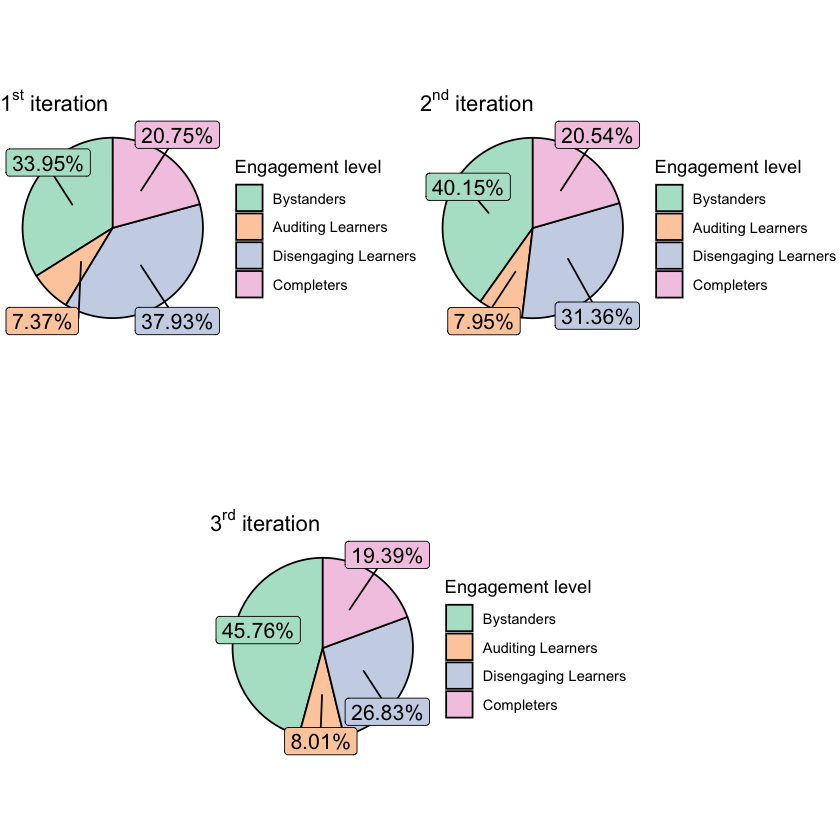

In [24]:
df1 <- usages1 %>% group_by(EngagementLevel) %>% tally(name = "value") %>%
          mutate(csum = rev(cumsum(rev(value))), 
         pos = if_else(is.na(value/2 + lead(csum, 1)), value/2, value/2 + lead(csum, 1)))

plot1 <- ggplot(df1, aes(x = "" , y = value, fill = factor(EngagementLevel))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  geom_label_repel(data = df1,
                   aes(y = pos, label = paste0(round(value / sum(value) * 100,
                                              digits = 2), "%")),
                   size = 4.5, nudge_x = 1, show.legend = FALSE) +
  scale_fill_brewer(palette = "Pastel2", name = "Engagement level",
                    labels = c('Bystanders', 'Auditing Learners',
                    'Disengaging Learners', 'Completers')) +
  
  theme_void() + labs(title = expression('1'^st*' iteration'))

df2 <- usages2 %>% group_by(EngagementLevel) %>% tally(name = "value") %>%
          mutate(csum = rev(cumsum(rev(value))), 
         pos = if_else(is.na(value/2 + lead(csum, 1)), value/2, value/2 + lead(csum, 1)))

plot2 <- ggplot(df2, aes(x = "" , y = value, fill = factor(EngagementLevel))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  geom_label_repel(data = df2,
                   aes(y = pos, label = paste0(round(value / sum(value) * 100,
                                              digits = 2), "%")),
                   size = 4.5, nudge_x = 1, show.legend = FALSE) +
  scale_fill_brewer(palette = "Pastel2", name = "Engagement level",
                    labels = c('Bystanders', 'Auditing Learners',
                    'Disengaging Learners', 'Completers')) +
  
  theme_void() + labs(title = expression('2'^nd*' iteration'))

df3 <- usages3 %>% group_by(EngagementLevel) %>% tally(name = "value") %>%
          mutate(csum = rev(cumsum(rev(value))), 
         pos = if_else(is.na(value/2 + lead(csum, 1)), value/2, value/2 + lead(csum, 1)))

plot3 <- ggplot(df3, aes(x = "" , y = value, fill = factor(EngagementLevel))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  geom_label_repel(data = df3,
                   aes(y = pos, label = paste0(round(value / sum(value) * 100,
                                              digits = 2), "%")),
                   size = 4.5, nudge_x = 1, show.legend = FALSE) +
  scale_fill_brewer(palette = "Pastel2", name = "Engagement level",
                    labels = c('Bystanders', 'Auditing Learners',
                    'Disengaging Learners', 'Completers')) +
  
  theme_void() + labs(title = expression('3'^rd*' iteration'))

g <- arrangeGrob(plot1, plot2, plot3, ncol = 2, layout_matrix=rbind(c(1,1,2,2), c(NA, 3, 3, NA)))
grid.arrange(plot1, plot2, plot3, ncol = 2, layout_matrix=rbind(c(1,1,2,2), c(NA, 3, 3, NA)))

# Inferential Statistics

Prepare data to apply hypothesis tests

In [ ]:
# Merge data
iter1 <- distinct(left_join(surveys1, usages1, by='Student_ID'))
iter2 <- distinct(left_join(surveys2, usages2, by='Student_ID'))
iter3 <- distinct(left_join(surveys3, usages3, by='Student_ID'))
iter3 <- iter3 %>% mutate_at(c('Curiosity.MOOC', 'Rencontres'), as.numeric)
df <- iter1 %>% full_join(iter2) %>% full_join(iter3)

In [6]:
df <- df %>% mutate(Country_HDI = case_when(Country_HDI == "TH" ~ "Very High",
                                            Country_HDI == "H" | Country_HDI == "M" ~ "Intermediate",
                                            Country_HDI == "B" ~ "Low"))
df$Country_HDI <- factor(df$Country_HDI, levels = c("Very High", "Intermediate", "Low"))

df <- df %>% mutate(Gender = case_when(Gender == "un homme" ~ "Male",
                                       Gender == "une femme" ~"Female"))
df$Gender <- factor(df$Gender, levels = c("Male", "Female"))
df$Exam.bin <- factor(df$Exam.bin)

## Gender and Viewed videos

In [7]:
df.t_test <- df %>% drop_na(c(Gender, last.video))
df.t_test %>%
  group_by(Gender) %>%
  get_summary_stats(last.video, type = "mean_sd")

Gender,variable,n,mean,sd
<fct>,<chr>,<dbl>,<dbl>,<dbl>
Male,last.video,6103,20.843,13.458
Female,last.video,2990,20.773,13.912


In [8]:
# Independent sample t-test
stat.test <- df.t_test %>% 
             t_test(last.video ~ Gender)
stat.test

,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,last.video,Male,Female,6103,2990,0.2292759,5764.39,0.819


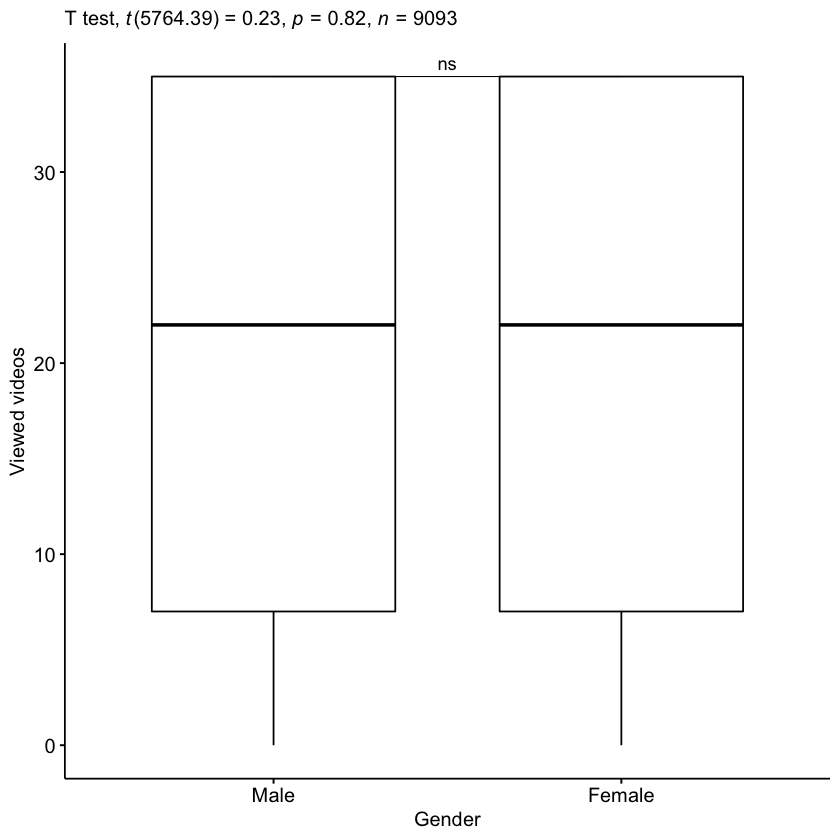

In [9]:
# Create a box-plot
bxp <- ggboxplot(
  df.t_test, x = "Gender", y = "last.video", 
  ylab = "Viewed videos", xlab = "Gender")

# Add p-value and significance levels
stat.test <- stat.test %>% add_xy_position(x = "Gender") %>%
             add_significance()
bxp + 
  stat_pvalue_manual(stat.test, tip.length = 0) +
  labs(subtitle = get_test_label(stat.test, detailed = TRUE))

## Country's HDI and Viewed videos

In [10]:
df.anova <- df %>% drop_na(c(Country_HDI, last.video))
df.anova %>%
  group_by(Country_HDI) %>%
  get_summary_stats(last.video, type = "mean_sd")

Country_HDI,variable,n,mean,sd
<fct>,<chr>,<dbl>,<dbl>,<dbl>
Very High,last.video,7264,21.665,13.580
Intermediate,last.video,667,18.099,13.846
Low,last.video,1032,16.633,12.638


In [11]:
# Levene test
levene <- df.anova %>% levene_test(last.video ~ Country_HDI)
levene

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
2,8960,11.85427,7.220328e-06


In [12]:
# Welch One way ANOVA test
res.aov <- df.anova %>% welch_anova_test(last.video ~ Country_HDI)
res.aov

,.y.,n,statistic,DFn,DFd,p,method
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,last.video,8963,83.45,2,1310.252,7.7e-35,Welch ANOVA


In [13]:
# Pairwise comparisons (Games-Howell)
pwc <- df.anova %>% games_howell_test(last.video ~ Country_HDI)
pwc

,.y.,group1,group2,estimate,conf.low,conf.high,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,last.video,Very High,Intermediate,-3.566385,-4.879709,-2.25306145,0.000,****
2,last.video,Very High,Low,-5.032584,-6.028394,-4.03677382,0.000,****
3,last.video,Intermediate,Low,-1.466199,-3.026445,0.09404754,0.071,ns


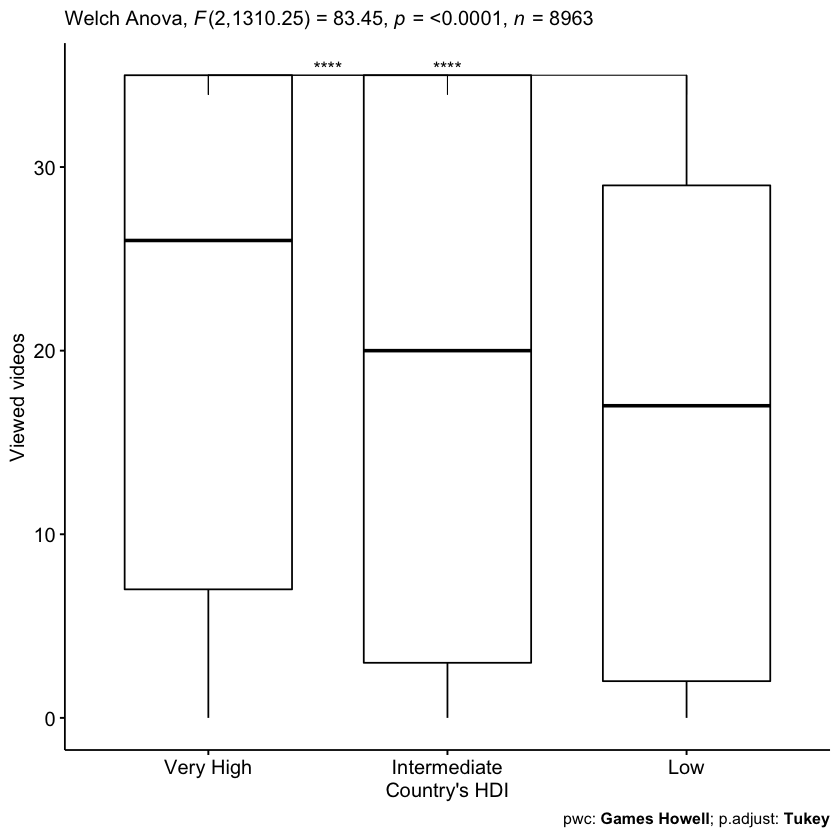

In [14]:
# Visualization: box plots with p-values
pwc <- pwc %>% add_xy_position(x = "Country_HDI")
ggboxplot(df.anova, x = "Country_HDI", y = "last.video",
          ylab = "Viewed videos", xlab = "Country's HDI") +
  stat_pvalue_manual(pwc, hide.ns = TRUE) +
  labs(
    subtitle = get_test_label(res.aov, detailed = TRUE),
    caption = get_pwc_label(pwc)
    )

## Genders and Country’s HDI groups

In [15]:
df.chisq <- df %>% drop_na(c(Country_HDI, Gender))

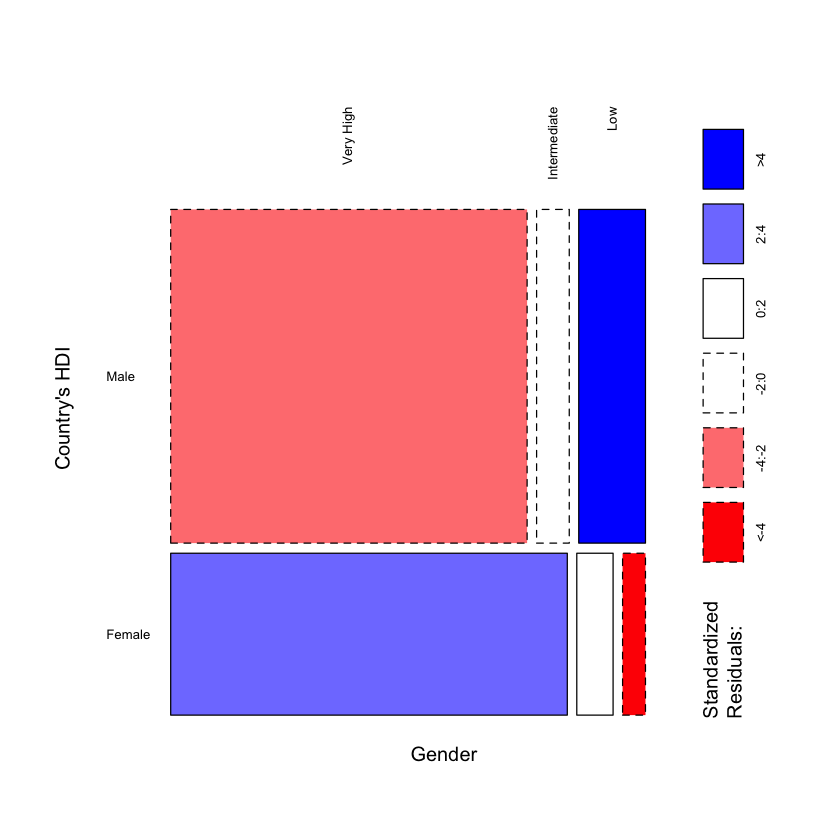

In [16]:
# Mosaic plot
mosaicplot( ~ Gender + Country_HDI, data = df.chisq,
           shade = TRUE, las=2, dir=c("h", "v"),
           main = NULL,
           xlab = "Gender", ylab = "Country's HDI")

In [17]:
# Chi-squared test
chisq <- chisq_test(df.chisq$Gender, df.chisq$Country_HDI)
chisq

,n,statistic,p,df,method,p.signif
,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,8957,179.0476,1.32e-39,2,Chi-square test,****


## Odds ratios of course accomplishment

In [18]:
# Logistic regression
lr <- glm(Exam.bin ~ Country_HDI + Gender, data=df, family = "binomial")
summary(lr)


Call:
glm(formula = Exam.bin ~ Country_HDI + Gender, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0553  -1.0553  -0.9008   1.3047   1.6997  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -0.29429    0.02882 -10.213  < 2e-16 ***
Country_HDIIntermediate -0.38536    0.08550  -4.507 6.57e-06 ***
Country_HDILow          -0.86831    0.07755 -11.197  < 2e-16 ***
GenderFemale            -0.01281    0.04662  -0.275    0.783    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12030  on 8950  degrees of freedom
Residual deviance: 11877  on 8947  degrees of freedom
  (7969 observations deleted due to missingness)
AIC: 11885

Number of Fisher Scoring iterations: 4


Note: dependent includes missing data. These are dropped.

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Warning message:
“Removed 2 rows containing missing values (geom_errorbarh).”


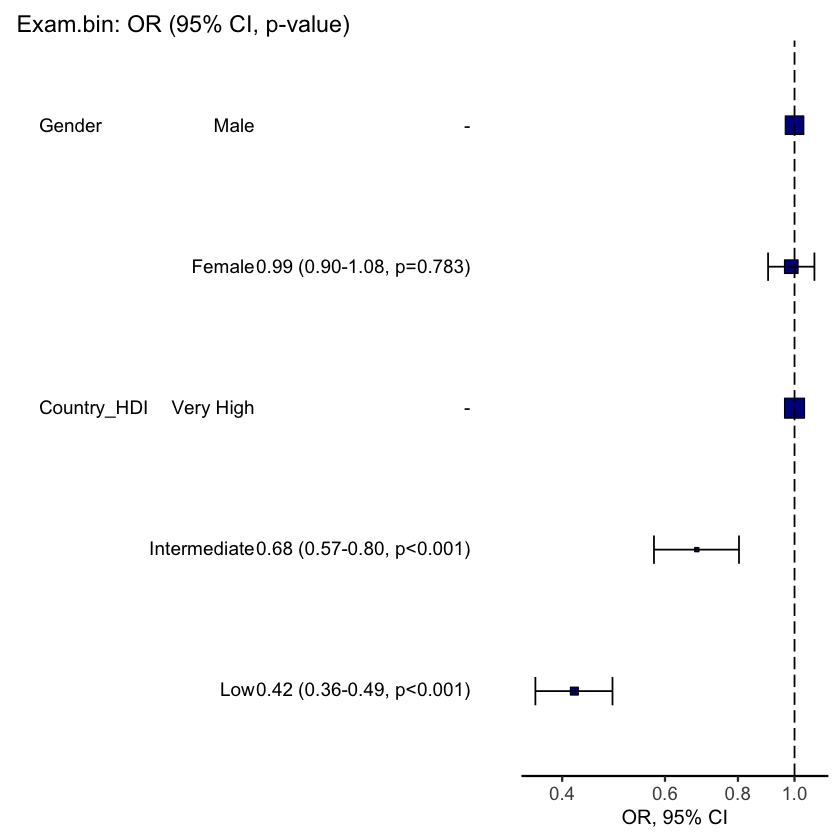

In [19]:
# OR plot
df %>%
  or_plot("Exam.bin", c("Gender","Country_HDI"), table_text_size=4, title_text_size=14,
    plot_opts=list(xlab("OR, 95% CI"), theme(axis.title = element_text(size=12))))

In [20]:
# Poisson Regression
pr <- glm(last.video ~ Country_HDI + Gender, data=df, family = "poisson")
pr


Call:  glm(formula = last.video ~ Country_HDI + Gender, family = "poisson", 
    data = df)

Coefficients:
            (Intercept)  Country_HDIIntermediate           Country_HDILow  
                3.08560                 -0.18080                 -0.26909  
           GenderFemale  
               -0.02596  

Degrees of Freedom: 8950 Total (i.e. Null);  8947 Residual
  (7969 observations deleted due to missingness)
Null Deviance:	    104100 
Residual Deviance: 102600 	AIC: 141100

# Survival Analysis

Prepare data to apply linear models

In [21]:
df <- df %>% mutate(status = case_when(last.video < 30 ~ 1,
                                           TRUE ~ 0))

df <- df %>% mutate(Group = case_when(EngagementLevel == 1 ~ "Auditing",
                                      EngagementLevel == 2 ~ "Disengaging"))
df$Group <- factor(df$Group, levels = c("Disengaging","Auditing"))

## Country's HDI

Call:
coxph(formula = Surv(last.video, status) ~ Country_HDI, data = df)

  n= 8963, number of events= 5349 
   (7957 observations deleted due to missingness)

                           coef exp(coef) se(coef)      z Pr(>|z|)    
Country_HDIIntermediate 0.33867   1.40308  0.04950  6.842  7.8e-12 ***
Country_HDILow          0.56331   1.75648  0.03808 14.791  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                        exp(coef) exp(-coef) lower .95 upper .95
Country_HDIIntermediate     1.403     0.7127     1.273     1.546
Country_HDILow              1.756     0.5693     1.630     1.893

Concordance= 0.538  (se = 0.003 )
Likelihood ratio test= 219.5  on 2 df,   p=<2e-16
Wald test            = 243.1  on 2 df,   p=<2e-16
Score (logrank) test = 248.9  on 2 df,   p=<2e-16


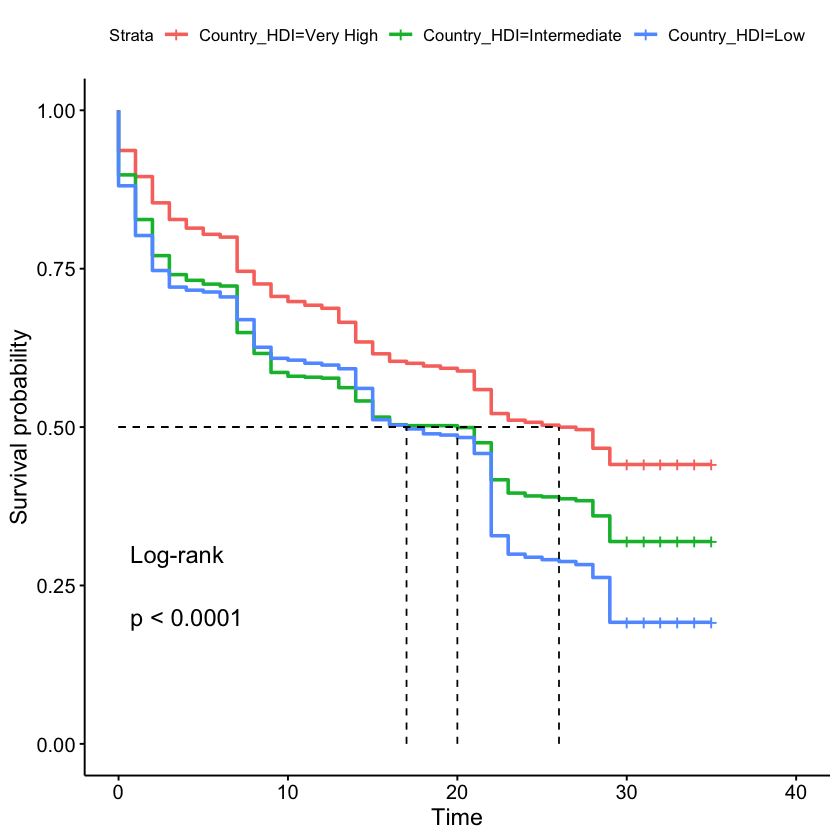

In [22]:
# Reference: Very High
summary(coxph(formula = Surv(last.video, status) ~ Country_HDI, data = df))
survival_HDI <- survfit(Surv(last.video, status) ~ Country_HDI, data = df)
ggsurvplot(
  survival_HDI,
  conf.int = FALSE,
  surv.median.line = c('hv'), 
  data = df, 
  pval = TRUE,
  pval.method = TRUE,
  risk.table = FALSE)

## Level of engagement

Call:
coxph(formula = Surv(last.video, status) ~ Group, data = df)

  n= 6252, number of events= 5294 
   (10668 observations deleted due to missingness)

                 coef exp(coef) se(coef)     z Pr(>|z|)    
GroupAuditing 0.78863   2.20038  0.03464 22.77   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              exp(coef) exp(-coef) lower .95 upper .95
GroupAuditing       2.2     0.4545     2.056     2.355

Concordance= 0.56  (se = 0.003 )
Likelihood ratio test= 446.6  on 1 df,   p=<2e-16
Wald test            = 518.4  on 1 df,   p=<2e-16
Score (logrank) test = 544.2  on 1 df,   p=<2e-16


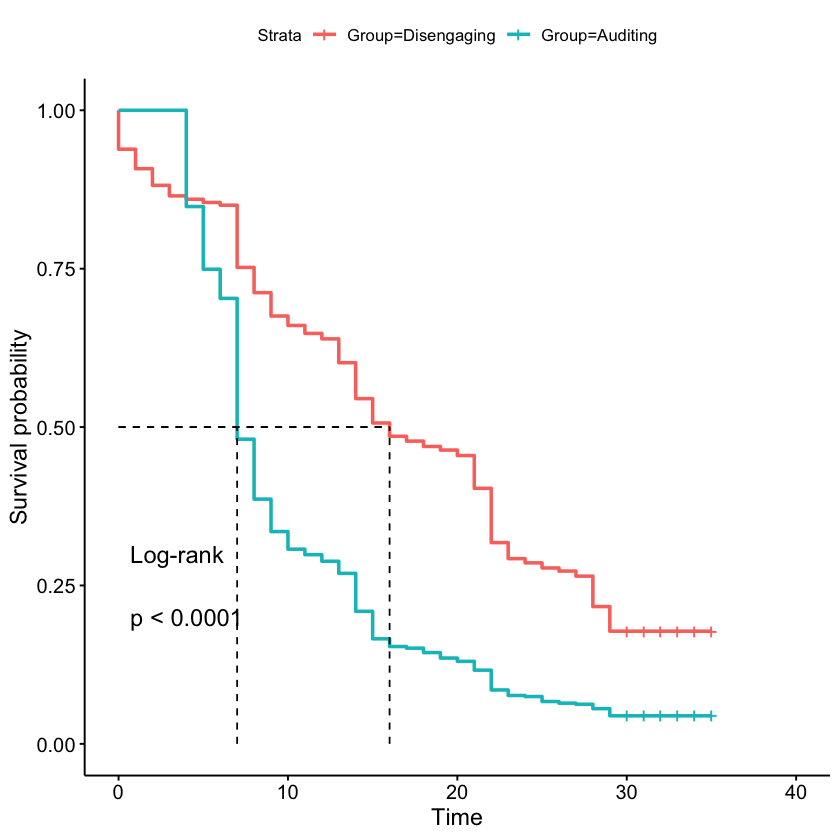

In [23]:
# Reference: Disengaging
summary(coxph(formula = Surv(last.video, status) ~ Group, data = df))
survival_Group <- survfit(Surv(last.video, status) ~ Group, data = df)
ggsurvplot(
  survival_Group,
  conf.int = FALSE,
  surv.median.line = c('hv'),
  data = df, 
  pval = TRUE,
  pval.method = TRUE,
  risk.table = FALSE)